In [1]:
## The goal of this notebook is to reproduce the results of the nonlinear backdoor 
## (from Vahid's paper) notebook (and corresponding python script)

## Module imports
import pandas as pd
import sys
sys.path.append("..")
import numpy as np
import torch
import matplotlib.pyplot as plt

from src.causalpfn.causal_estimator import CausalEstimator
from src.causalpfn import ATEEstimator
from functools import reduce

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
## MAIN HYPERPARAMETER
N_DISC_VALUES = [2, 3]

## Main body
# Discretization function
def discretize_treatment(T: np.ndarray, N: int) -> np.ndarray:
    """Returns discretized version of T. Assumes range of T is [0, 1].

    Args:
        T (np.ndarray): The raw treatment data 
        N (int): The number of discretized treatment values to use

    Returns:
        np.ndarray: The discretized treatment data
    """
    dt = 1 / (N - 1)
    T_discrete = np.round(np.array(T, dtype=np.float32) / dt) * dt

    return T_discrete

# RMSE function
def calculate_rmse(y_pred, y_true):
    result = np.mean(np.power(y_pred - y_true, 2))
    result = np.sqrt(result)

    return result

In [3]:
## Synthetic data generation

# Generate synthetic data, using the DGP from Vahid's paper - nonlinear backdoor
np.random.seed(42)
n, d = 2000, 1
X = np.random.normal(2, 1, size=(n, d)).astype(np.float32)
T = (0.1 * X[:, 0] ** 2 - X[:, 0] + np.random.normal(1, 2, size=n)).astype(np.float32)
T = T - T.min() # Rescale
T = T / T.max() # Rescale
Y = (0.5 * T ** 2 - T * X[:, 0] + np.random.normal(0, 2, size=n)).astype(np.float32)
def drf(t): return 0.5 * t ** 2 - 2 * t # true dose-response funcion

df = pd.concat([
    pd.DataFrame(data=X, columns=["x"]), 
    pd.DataFrame(data=T, columns=["T"]), 
    pd.DataFrame(data=Y, columns=["Y"])
    ], axis=1)

In [ ]:
## Inference cell

list_of_epos = [] # [(N_DISC, epos)], epos = [(mu_t0, mu_t1), (mu_t1, mu_t2), ... ]
list_of_ates = [] # [(N_DISC, ates)], ates = [ATE(t0, t1), ATE(t1, t2), ...]

for N_DISC in N_DISC_VALUES:
    print(f"N_DISC: {N_DISC}")
    discrete_treatment_levels = np.linspace(0, 1, N_DISC)
    T_discrete = discretize_treatment(T, N_DISC)
    epos = []
    ates = []
    for i, t in enumerate(discrete_treatment_levels[:-1]):
        t0, t1 = discrete_treatment_levels[i], discrete_treatment_levels[i + 1]
        ids = (np.abs(T_discrete - t0) < 1e-4) | (np.abs(T_discrete - t1) < 1e-4)
        T_temp = np.where(np.abs(T_discrete[ids] - t0) < 1e-4, 0, 1).astype(np.float32)
        X_temp = X[ids].astype(np.float32)
        Y_temp = Y[ids].astype(np.float32)
        # to predict ate
        causalpfn_ate = ATEEstimator(
            device=device,
            verbose=True
        )
        causalpfn_ate.fit(X_temp, T_temp, Y_temp)
        ate = causalpfn_ate.estimate_ate()
        ates.append(ate)
        # to predict cepo
        X_context = X_temp 
        t_context = T_temp
        y_context = Y_temp
        X_query = X_temp 
        t_all_ones = np.ones(X_query.shape[0], dtype=X_query.dtype)
        t_all_zeros = np.zeros(X_query.shape[0], dtype=X_query.dtype)
        causalpfn_cepo = CausalEstimator(
            device=device,
            verbose=True
        )
        causalpfn_cepo.fit(X_temp, T_temp, Y_temp)
        mu_vals = causalpfn_cepo._predict_cepo(
            X_context=X_context,
            t_context=t_context,
            y_context=y_context,
            X_query=np.concatenate([X_query, X_query], axis=0),
            t_query=np.concatenate([t_all_zeros, t_all_ones], axis=0),
            temperature=causalpfn_cepo.prediction_temperature,
        )
        mu_0 = (mu_vals[: X_query.shape[0]]).mean()
        mu_1 = (mu_vals[X_query.shape[0] :]).mean()
        epos.append((mu_0, mu_1))
    list_of_epos.append((N_DISC, epos))
    list_of_ates.append((N_DISC, ates))


N_DISC: 2


Predicting CEPO: 100%|██████████| 4000/4000 [00:13<00:00, 286.05it/s]


N_DISC: 3


Predicting CEPO: 100%|██████████| 3624/3624 [00:10<00:00, 347.50it/s]


In [5]:
# epos = [(mu_t0, mu_t1), (mu_t1, mu_t2), (mu_t2, mu_t3)]
# Take the first tuple whole, then just the second entry in the remaining tuples

In [6]:
epos = list_of_epos[1][1] # epos we want to visualize
ates = list_of_ates[1][1] # ates we want to visualize
col_names = ["mu_0_est", "mu_0.5_est", "mu_1_est", "ATE from _predict_cepo", "ATE from estimate_ate"]
row_names = ["[0, 0.5]", "[0.5, 1]"]
df = pd.DataFrame("NA", index=row_names, columns=col_names) 
discrete_treatment_levels = [0, 0.5, 1]
intermediate_treatment_levels = discrete_treatment_levels[1:-1]
df.loc["[0, 0.5]", "mu_0_est"] = epos[0][0]
df.loc["[0.5, 1]", "mu_1_est"] = epos[-1][-1]
for i in range(0, len(intermediate_treatment_levels)):
    row_1 = f"[{discrete_treatment_levels[i]}, {discrete_treatment_levels[i + 1]}]"
    row_2 = f"[{discrete_treatment_levels[i + 1]}, {discrete_treatment_levels[i + 2]}]"
    col = f"mu_{intermediate_treatment_levels[i]}_est"
    df.loc[row_1, col] = epos[i][1]
    df.loc[row_2, col] = epos[i + 1][0]

for i in range(len(discrete_treatment_levels) - 1):
    left = df.loc[row_names[i], f"mu_{discrete_treatment_levels[i]}_est"]
    right = df.loc[row_names[i], f"mu_{discrete_treatment_levels[i + 1]}_est"]
    df.loc[row_names[i], "ATE from _predict_cepo"] = right - left
    df.loc[row_names[i], "ATE from estimate_ate"] = ates[i]

df

,mu_0_est,mu_0.5_est,mu_1_est,ATE from _predict_cepo,ATE from estimate_ate
"[0, 0.5]",-0.326206,-0.961495,NA,-0.635289,-0.635289
"[0.5, 1]",NA,-0.934088,-0.214735,0.719353,0.719353


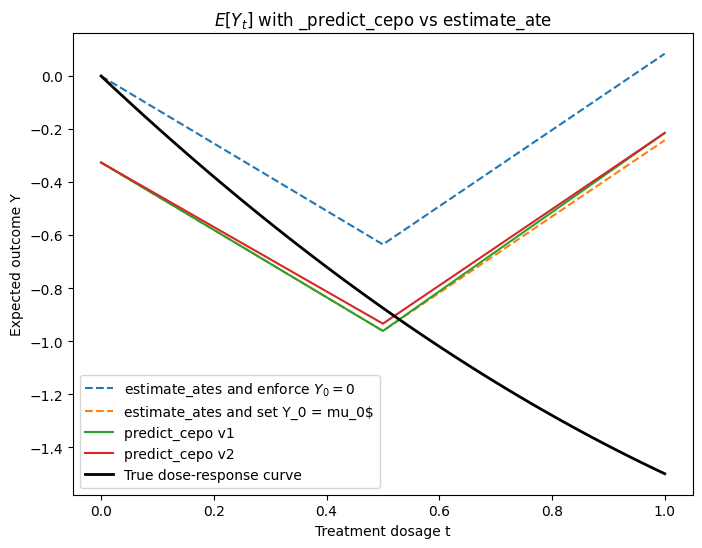

In [ ]:
fig = plt.figure(figsize=(8, 6))

# Plot ate curve
plt.plot(discrete_treatment_levels, [0, 0 + ates[0], 0 + ates[0] + ates[1]], 
         '--',
         label="estimate_ates and enforce $Y_0 = 0$") # With Y_0 = 0 enforced
plt.plot(discrete_treatment_levels, [epos[0][0], epos[0][0] + ates[0], epos[0][0] + ates[0] + ates[1]], 
         '--',
         label="estimate_ates and set Y_0 = mu_0$") # With Y_0 = mu_0_est

# # Plot epo curve
plt.plot(
    discrete_treatment_levels, [epos_[0], epos_[1][0], epos_[2]], 
    label="predict_cepo v1"
)
plt.plot(
    discrete_treatment_levels, [epos_[0], epos_[1][1], epos_[2]], 
    label="predict_cepo v2"
)

# True dose-response curve
plt.plot(np.linspace(0.0, 1.0, 100), drf(np.linspace(0.0, 1.0, 100)),
         label="True dose-response curve", linewidth=2, c='k', zorder=15)

plt.title("$E[Y_t]$ with _predict_cepo vs estimate_ate") # Note E[Y_t] = E[Y | do(T = t)]
plt.xlabel("Treatment dosage t")
plt.ylabel("Expected outcome Y")
plt.legend()

In [4]:
df = pd.read_csv("../output/11-13-2025/cepo_vs_ate.csv",
                 index_col=[0, 1],
                 skipinitialspace=True)

In [31]:
df_N

EPOs      ATEs
N_DISC subinterval                                      
10     0              (-0.3169264, -0.4013069) -0.084380
       1            (-0.31029898, -0.76858056) -0.458282
       2              (-0.7041979, -0.8694781) -0.165280
       3             (-0.85165215, -1.0026038) -0.150952
       4            (-0.95253193, -0.99748373) -0.044952
       5             (-0.94110376, -0.9677971) -0.026693
       6              (-0.8594732, -0.7594388)  0.100034
       7              (-0.37508637, 0.6508898)  1.025976
       8              (0.90394276, 0.13801248) -0.765930

In [48]:
y_left

[np.float32(-0.3169264),
 np.float32(-0.31029898),
 np.float32(-0.7041979),
 np.float32(-0.85165215),
 np.float32(-0.95253193),
 np.float32(-0.94110376),
 np.float32(-0.8594732),
 np.float32(-0.37508637),
 np.float32(0.90394276),
 np.float32(0.13801248)]

In [53]:
y_right

[np.float32(-0.3169264),
 np.float32(-0.4013069),
 np.float32(-0.76858056),
 np.float32(-0.8694781),
 np.float32(-1.0026038),
 np.float32(-0.99748373),
 np.float32(-0.9677971),
 np.float32(-0.7594388),
 np.float32(0.6508898),
 np.float32(0.13801248)]

In [54]:
np.maximum(y_left, y_right)

array([-0.3169264 , -0.31029898, -0.7041979 , -0.85165215, -0.95253193,
       -0.94110376, -0.8594732 , -0.37508637,  0.90394276,  0.13801248],
      dtype=float32)

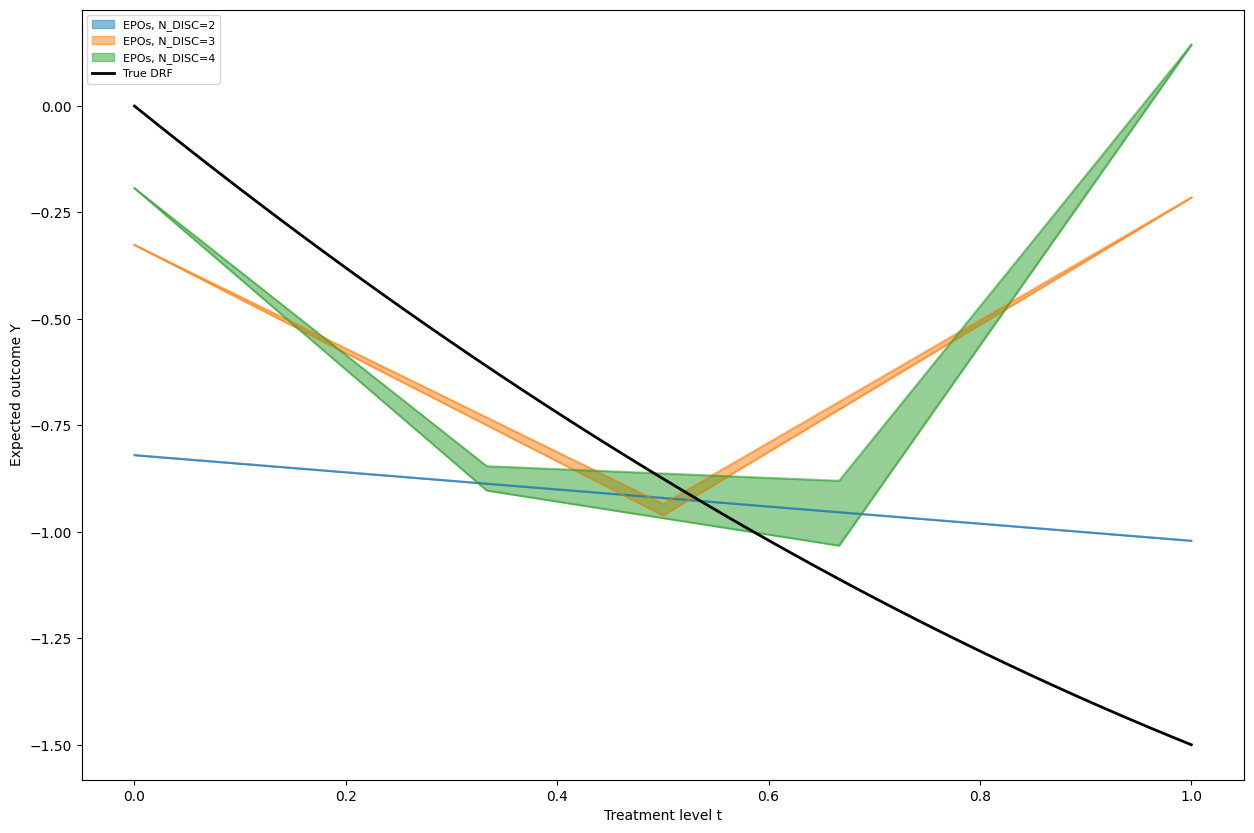

In [106]:
fig = plt.figure(figsize=(15, 10))

# for coloring
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()["color"]

for i, N in enumerate(range(2, 5)):
    t_linspace = np.linspace(0, 1, N)
    df_N = df.loc[[N]]
    mu_0 = np.float32(df_N["EPOs"].values[0].split(",")[0][1:]) # get epo_0
    # plot ATE curve starting at epo_0
    # ates = df_N["ATEs"].values
    # vals = [mu_0] + [mu_0 + sum(ates[:i]) for i in range(1, len(ates) + 1)] # discrete FTC
    # plt.plot(t_linspace, vals, 
    #          '--',
    #          linewidth=1,
    #          label=f"ATEs, N_DISC={N}")
    # prepare EPO values ("lower" and "upper")
    y_left = [np.float32(df_N["EPOs"].values[j].split(",")[0][1:]) for j in range(len(df_N))] # right now importing from a csv gives awful string stuff
    y_right = [np.float32(df_N["EPOs"].values[j].split(",")[1][:-1]) for j in range(len(df_N))]
    y_left.append(y_right[-1]) # add last point
    y_right = [y_left[0]] + y_right # add first point
    y_left = np.array(y_left) # array-ify
    y_right = np.array(y_right) 
    y_upper = np.maximum(y_left, y_right)
    y_lower = np.minimum(y_left, y_right)
    # plot EPO values
    plt.plot(t_linspace, y_upper,
             color=colors[i],
             alpha=0.5)
    plt.plot(t_linspace, y_lower,
             color=colors[i],
             alpha=0.5)    
    plt.fill_between(t_linspace, y_upper, y_lower, 
                     color=colors[i],
                     alpha=0.5,
                     label=f"EPOs, N_DISC={N}")
    
# true drf
t_mesh = np.linspace(0, 1, 100)
plt.plot(t_mesh, drf(t_mesh), 
         linewidth=2,
         c="k",
         label="True DRF")

plt.xlabel("Treatment level t")
plt.ylabel("Expected outcome Y")
plt.legend(fontsize=8)

plt.show()

In [157]:
np.float32(df_N["EPOs"].values[0].split(",")[0][1:])

np.float32(-0.8198656)

In [188]:
sum(np.array([12.4, 35.4, 12.3])[:2])

np.float64(47.8)

In [50]:
# To get a good RMSE estimate for all the predictions, need a large mesh
fine_mesh = np.linspace(0, 1, 100) # fixed, fine mesh
t_mesh = [np.linspace(0, 1, N_DISC) for N_DISC in N_DISC_VALUES] # to ensure all discrete treatment values are hit
t_mesh += [fine_mesh]
t_mesh = reduce(np.union1d, tuple(t_mesh))

# Get RMSE by evaluating on each of the t_mesh points
rmse_dict = dict()
y_true = drf(t_mesh)
for N_DISC, epos in list_of_epos:
    epos_to_plot = [epos[0][0], epos[0][1]] + [mu_1 for (mu_0, mu_1) in epos[1:]]
    y_pred = np.interp(t_mesh, np.linspace(0, 1, N_DISC), epos_to_plot)
    error = calculate_rmse(y_pred, y_true)
    rmse_dict[N_DISC] = np.round(error, 4)

# Create dataframe
df = pd.DataFrame.from_dict(rmse_dict, orient="index", columns=["RMSE"])
df

,RMSE
2,0.3888
3,0.5418


<Axes: title={'center': 'RMSE of different choices of N_DISC'}, xlabel='N_DISC', ylabel='RMSE'>

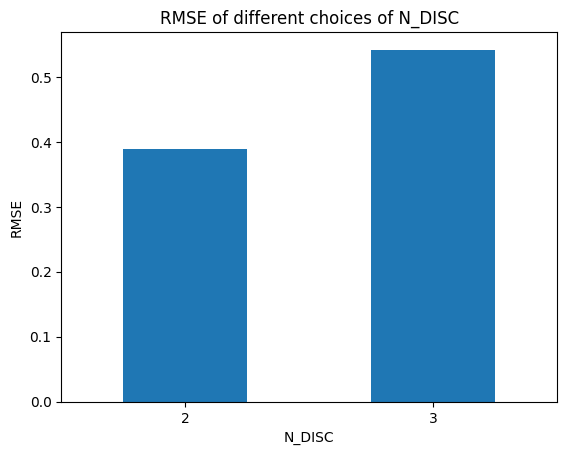

In [51]:
df.plot.bar(rot=0, title="RMSE of different choices of N_DISC", xlabel="N_DISC", ylabel="RMSE", legend=False)

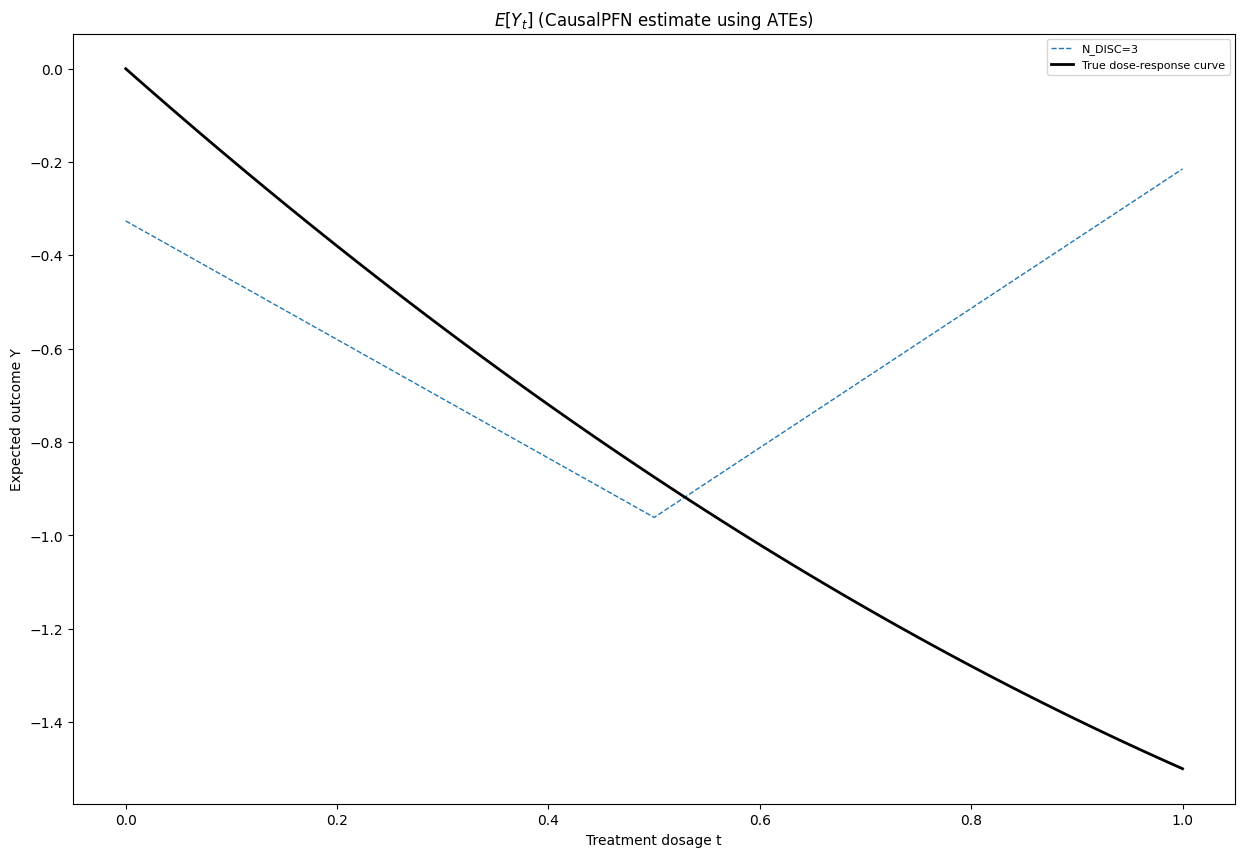

In [53]:
fig = plt.figure(figsize=(15, 10))

# Plot predictions

for N_DISC, epos in list_of_epos[1:2]:
    epos_to_plot = [epos[0][0], epos[0][1]] + [mu_1 for (mu_0, mu_1) in epos[1:]]
    if df.loc[N_DISC, "RMSE"] == df.min().values: # Emphasize best prediction
        plt.plot(np.linspace(0.0, 1.0, N_DISC), epos_to_plot, '-', linewidth=2,
                 label=f"N_DISC={N_DISC} (Best)", c="blue", zorder=14)
    else:
        plt.plot(np.linspace(0.0, 1.0, N_DISC), epos_to_plot, '--', linewidth=1,
                 label=f"N_DISC={N_DISC}")

# True dose-response curve
plt.plot(np.linspace(0.0, 1.0, 100), drf(np.linspace(0.0, 1.0, 100)),
         label="True dose-response curve", linewidth=2, c='k', zorder=15)

plt.title("$E[Y_t]$ (CausalPFN estimate using ATEs)") # Note E[Y_t] = E[Y | do(T = t)]
plt.xlabel("Treatment dosage t")
plt.ylabel("Expected outcome Y")

plt.legend(fontsize=8)
plt.show()